In [1]:
!pip install chess pandarallel

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.5 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=5203793ea0c395c733072d8b0c508fd2a37f62890ee5f68506173e7e6690a48b
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from pandarallel import pandarallel
from multiprocessing import Pool
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import chess
import time 

random.seed(42)
np.random.seed(42)

In [3]:
values = {
    "P": 1,
    "R": 5,
    "B": 3,
    "N": 3,
    "K": 0,
    "Q": 9,
    "p": -1,
    "r": -5,
    "b": -3,
    "n": -3,
    "k": 0,
    "q": -9
}

def win_lose_draw(evaluation):
    if evaluation < -10:
        return 0
    if evaluation < -1.5:
        return 1
    if evaluation < 1.5:
        return 2
    if evaluation < 10:
        return 3
    return 4

def tan_eval_categories(evaluation):
    if evaluation < -.5:
        return 0
    if evaluation > .5:
        return 1
    return 2

def eval_to_int(evaluation):
    return int(evaluation) / 100

In [4]:
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
df = pd.read_csv("/kaggle/input/no-check-mate-fen/final_data.csv")

In [6]:
count_pieces = lambda fen, pat=re.compile(r"[a-zA-Z]"): len(re.findall(pat, fen.split(' ')[0]))
transform_eval = lambda x: np.arctan(x / 3)
untransform_eval = lambda x: 3 * np.tan(x)

In [7]:
df["Pieces"] = df["FEN"].parallel_map(count_pieces)
df["Evaluation"] = df["Evaluation"].parallel_map(eval_to_int)
df["Normalized Evaluation"] = transform_eval(df["Evaluation"])
df["Normalized WLD"] = df["Normalized Evaluation"].parallel_map(tan_eval_categories)

In [8]:
piece_to_layer = {
        'R': 1,
        'N': 2,
        'B': 3,
        'Q': 4,
        'K': 5,
        'P': 6,
        'p': 7,
        'k': 8,
        'q': 9,
        'b': 10,
        'n': 11,
        'r': 12
}

In [9]:
def to_bitboard(fen):
    boards = np.zeros((29, 8, 8), dtype=np.uint8)
    board = chess.Board(fen)
    color = bool(board.turn)
    cr = board.castling_rights
    wkcastle = bool(cr & chess.H1)
    wqcastle = bool(cr & chess.A1)
    bkcastle = bool(cr & chess.H8)
    bqcastle = bool(cr & chess.A8)

    boards[0, :, :]  = color
    boards[25, :, :] = wkcastle
    boards[26, :, :] = wqcastle
    boards[27, :, :] = bkcastle
    boards[28, :, :] = bqcastle

    piece_map = board.piece_map()
    for i, p in piece_map.items():
        rank, file = to_square(i)
        piece = p.symbol()
        boards[piece_to_layer[piece], rank, file] = 1
        for sq in board.attacks(i):
            attack_rank, attack_file = to_square(sq)
            boards[piece_to_layer[piece] + 12, attack_rank, attack_file] = 1
    return boards

def to_square(number):
    rank, file = divmod(number, 8)
    return 7 - rank, file

# In bitboard
def print_bitboard(boards):
    np.set_printoptions(linewidth=150)
    for i in range(boards.shape[0]):
        print(f"Layer {i}:")
        print(boards[i])
        print("\n")

In [10]:
def safe_sample(group, n):
    return group.sample(n=n) if len(group) >= n else group

bdf = df[df["Pieces"] >= 5].groupby("Pieces").apply(lambda x: safe_sample(x, 10000000)).reset_index(drop=True)

# Áp dụng lại cho các nhóm "Normalized WLD"
bbdf = bdf.groupby("Normalized WLD").apply(lambda x: safe_sample(x, 2000000)).reset_index(drop=True)

/tmp/ipykernel_34/1923606251.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bdf = df[df["Pieces"] >= 5].groupby("Pieces").apply(lambda x: safe_sample(x, 10000000)).reset_index(drop=True)
/tmp/ipykernel_34/1923606251.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bbdf = bdf.groupby("Normalized WLD").apply(lambda x: safe_sample(x, 2000000)).reset_index(drop=True)


In [11]:
l = len(bbdf)
bbdf = bbdf.sample(frac=1)
train_df, test_df, cv_df = bbdf[:int(.8 * l)], bbdf[int(.8 * l): int(.9 * l)], bbdf[int(.9 * l):]

In [12]:
import gc
gc.collect()

0

In [13]:
class ChessDataset(Dataset):
    def __init__(self, df):
        self.fens = torch.from_numpy(np.array([*map(to_bitboard, df["FEN"])], dtype=np.uint8))
        self.evals = torch.Tensor([[x] for x in df["Normalized Evaluation"]])
        self._len = len(self.evals)
        
    def __len__(self):
        return self._len
    
    def __getitem__(self, index):
        return self.fens[index], self.evals[index]

d_train, d_test, d_cv = map(ChessDataset, [train_df, test_df, cv_df])

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model = nn.Sequential(
    nn.Conv2d(29, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Dropout(0.4),
    nn.Conv2d(256, 1024, kernel_size=2, stride=1),
    nn.ReLU(),
    nn.BatchNorm2d(1024),
    nn.Dropout(0.4),
    nn.Conv2d(1024, 512, kernel_size=2, stride=1),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.Dropout(0.4),
    nn.Conv2d(512, 256, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Dropout(0.4),
    nn.Flatten(),
    nn.Linear(1024, 512),
    nn.Dropout(0.2),
    nn.Linear(512, 1) 
).to(device)

def init_weights(m):
    try:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    except Exception:
        return

model.apply(init_weights)

Sequential(
  (0): Conv2d(29, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.4, inplace=False)
  (7): Conv2d(256, 1024, kernel_size=(2, 2), stride=(1, 1))
  (8): ReLU()
  (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Dropout(p=0.4, inplace=False)
  (11): Conv2d(1024, 512, kernel_size=(2, 2), stride=(1, 1))
  (12): ReLU()
  (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Dropout(p=0.4, inplace=False)
  (15): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (16): ReLU()
  (17): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (18): Dropout(p=0.4, inplace=False)
  (19): 

In [19]:
batch_size = 128
num_work = 2
print("Converting to pytorch Dataset...")
train_loader = DataLoader(dataset=d_train, batch_size=batch_size, shuffle=True, num_workers=num_work)
cv_loader = DataLoader(dataset=d_cv, batch_size=batch_size, shuffle=True, num_workers=num_work)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003) 
print("Done")

Converting to pytorch Dataset...
Done


In [20]:
import time
import torch

train_losses, val_losses = [], []

best_val_loss = float('inf')
patience = 10
counter = 0
checkpoint_path = 'best_model.pth'

for epoch in range(1000):
    start_time = time.time()
    running_loss = []

    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        y_pred = model(data.float())
        loss = criterion(y_pred, target)
        
        running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    # Calculate average training loss for the epoch
    train_loss = sum(running_loss) / len(running_loss)
    train_losses.append(train_loss)

    # Print training loss for the epoch
    print(f"[TRAIN] epoch: {epoch + 1:5}, loss: {train_loss:10}, time: {time.time() - start_time:.2f} seconds", end="\t")

    # Validation loop
    model.eval()  # Set the model to eval mode
    running_loss = []
    with torch.no_grad():
        for data, target in cv_loader:
            data, target = data.to(device), target.to(device)
            y_pred = model(data.float())
            loss = criterion(y_pred, target)
            running_loss.append(loss.item())
        
    # Calculate average validation loss for the epoch
    val_loss = sum(running_loss) / len(running_loss)
    val_losses.append(val_loss)

    # Print validation loss for the epoch
    print(f"[VAL] epoch: {epoch + 1:5}, loss: {val_loss:10}, time: {time.time() - start_time:.2f} seconds")

    # Check early stopping condition and save model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Validation loss decreased ({val_loss:.6f}). Saving model ...")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

print('Finished Training')
# Load the last checkpoint with the best model
model.load_state_dict(torch.load(checkpoint_path))
torch.save(model.state_dict(), 'final_model.pth')
print('Finished Training and Best Model Saved')

[TRAIN] epoch:     1, loss: 0.26993932749525673, time: 1528.34 seconds	[VAL] epoch:     1, loss: 0.2041803349605166, time: 1641.68 seconds
Validation loss decreased (0.204180). Saving model ...
[TRAIN] epoch:     2, loss: 0.20451116611858508, time: 1527.95 seconds	[VAL] epoch:     2, loss: 0.17091929599291267, time: 1642.59 seconds
Validation loss decreased (0.170919). Saving model ...
[TRAIN] epoch:     3, loss: 0.18634894754579082, time: 1527.11 seconds	[VAL] epoch:     3, loss: 0.16112142069931543, time: 1641.32 seconds
Validation loss decreased (0.161121). Saving model ...
[TRAIN] epoch:     4, loss: 0.1766433377658731, time: 1524.33 seconds	[VAL] epoch:     4, loss: 0.15575807867299632, time: 1636.63 seconds
Validation loss decreased (0.155758). Saving model ...
[TRAIN] epoch:     5, loss: 0.17021041280149243, time: 1521.61 seconds	[VAL] epoch:     5, loss: 0.14667507227340112, time: 1633.30 seconds
Validation loss decreased (0.146675). Saving model ...
[TRAIN] epoch:     6, loss:

KeyboardInterrupt: 

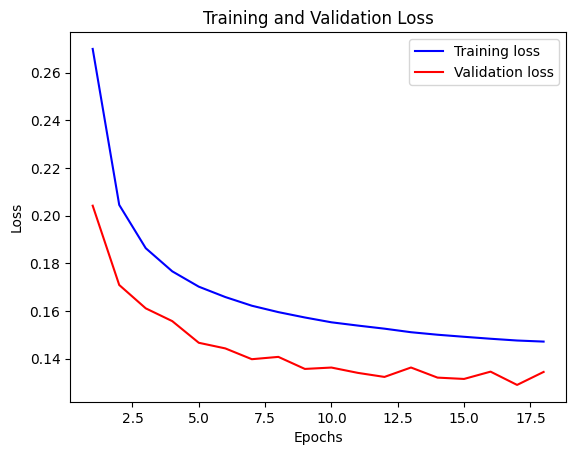

In [22]:
# Plotting the losses
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()